In [82]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "p8_ee_Zbb_ecm91_EvtGen_Bd2DstTauNu"

#Load 1 sub-file of 100k events
file = uproot.open(f"/eos/experiment/fcc/ee/generation/DelphesEvents/fcc_tmp/{file_type}/events_005601862.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
r_container = "ReconstructedParticles"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)

n_keep = 100000

r = tree.arrays(keep_vars,how="zip")[:n_keep]

Get kaons and pions used to make combinations

In [83]:
r[r_c,'p'] = kinematics.calc_p(r,r_c)
p_cut = r[r_c,"p"] > 0.
r = r[p_cut]

#Pions
pi_cut = abs(r[r_c,"mass"] - lp.pi_plus.mass/1000.) < 1e-4
r["pi"] = r[r_c][pi_cut]
p_cut = r["pi"]["p"] > 1.
r["pi"] = r["pi"][p_cut]

#Kaons
k_cut = abs(r[r_c,"mass"] - lp.K_plus.mass/1000.) < 1e-4
r["k"] = r[r_c][k_cut]
p_cut = r["k"]["p"] > 1.
r["k"] = r["k"][p_cut]

#Slow pions (without p cut)
slow_pi_cut = abs(r[r_c,"mass"] - lp.pi_plus.mass/1000.) < 1e-4
r["slow_pi"] = r[r_c][slow_pi_cut]

Build $D^0$

In [84]:
D0 = ak.cartesian({"k": r["k"], "pi": r["pi"]})
D0_cut = np.sign(D0["k","charge"]) != np.sign(D0["pi","charge"])
D0 = D0[D0_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D0["mass"] = kinematics.mass([D0["k"], D0["pi"]], [PDG_K_m, PDG_pi_m])

PDG_D0_m = lp.D_0.mass/1000.
D0_window = 0.01
D0_cut = abs(D0["mass"] - PDG_D0_m) < D0_window
D0 = D0[D0_cut]

Build $D^*$

In [85]:
Dst = ak.cartesian({"D0_k": D0["k"], "D0_pi": D0["pi"], "slow_pi": r["slow_pi"]})
Dst_cut = np.sign(Dst["D0_k","charge"]) != np.sign(Dst["slow_pi","charge"]) 
Dst = Dst[Dst_cut]

Dst["mass"] = kinematics.mass([Dst["D0_k"], Dst["D0_pi"], Dst["slow_pi"]], [PDG_K_m, PDG_pi_m, PDG_pi_m])
Dst["D0_M"] = kinematics.mass([Dst["D0_k"], Dst["D0_pi"]], [PDG_K_m, PDG_pi_m])
Dst["Delta_M"] = Dst["mass"] - Dst["D0_M"]

PDG_Dst_m = lp.Dst_2010_plus.mass/1000.
Dst_window = 0.025
Dst_cut = abs(Dst["mass"] - PDG_Dst_m) < Dst_window
Dst = Dst[Dst_cut]
Dst_Delta_M_low_cut_val = 0.1435 
Dst_Delta_M_high_cut_val = 0.1475
Dst_Delta_M_low_cut = Dst["Delta_M"] >= Dst_Delta_M_low_cut_val
Dst_Delta_M_high_cut = Dst["Delta_M"] <= Dst_Delta_M_high_cut_val
Dst_Delta_M_cut = np.logical_and(Dst_Delta_M_low_cut, Dst_Delta_M_high_cut)
Dst = Dst[Dst_Delta_M_cut]

Build $\tau \to 3\pi$ candidate

In [86]:
tau = ak.combinations(r["pi"],3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

tau["mass"] = kinematics.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

#Invariant mass of opposite charge pions
tau["mass_13"] = kinematics.mass([tau["pi_1"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m])
tau["mass_23"] = kinematics.mass([tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m])

#Require that one or the other pipi combination is within rho region
tau_mass_13_cut = abs(tau["mass_13"] - lp.rho_770_0.mass/1000.) < 0.1
tau_mass_23_cut = abs(tau["mass_23"] - lp.rho_770_0.mass/1000.) < 0.1
tau_pipi_mass_cut = np.logical_or(tau_mass_13_cut, tau_mass_23_cut)

tau = tau[tau_pipi_mass_cut]

Make $B$ candidates

In [87]:
B = ak.cartesian({"Dst": Dst, "tau": tau})
B_charge_cut = np.sign(B["Dst","slow_pi","charge"]) != np.sign(B["tau","pi_1","charge"]) 
B = B[B_charge_cut]

B["mass"] = kinematics.mass([B["Dst","slow_pi"], 
                             B["Dst","D0_k"], 
                             B["Dst","D0_pi"], 
                             B["tau","pi_1"],
                             B["tau","pi_2"],
                             B["tau","pi_3"]
                            ], 
                            [PDG_pi_m, 
                             PDG_K_m, 
                             PDG_pi_m,
                             PDG_pi_m,
                             PDG_pi_m,
                             PDG_pi_m
                            ])

B_mass_cut_low_val = 2.8
B_mass_cut_high_val = 5.4
B_mass_cut_low = B["mass"] >= B_mass_cut_low_val
B_mass_cut_high = B["mass"] <= B_mass_cut_high_val
B_mass_cut = np.logical_and(B_mass_cut_low,B_mass_cut_high)
B = B[B_mass_cut]

Plot reconsrructed $B$ mass 

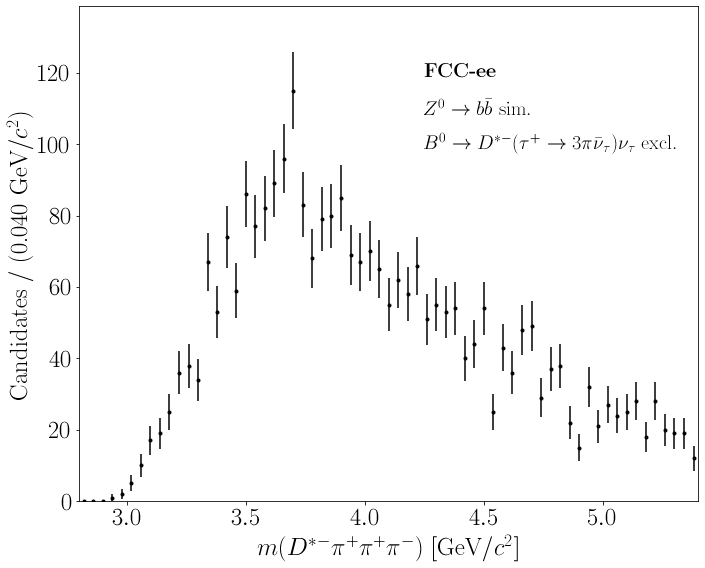

In [88]:
fig,ax = plt.subplots(figsize=(10,8))
low = B_mass_cut_low_val
high = B_mass_cut_high_val
bin_width = 0.04
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(ak.flatten(B["mass"]).tolist(), bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(D^{*-}\pi^+\pi^+\pi^-)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(4.25,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(4.25,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(4.25,0.74*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_B_M.pdf")

Plot $\tau$ mass for the selected $B$ candidates

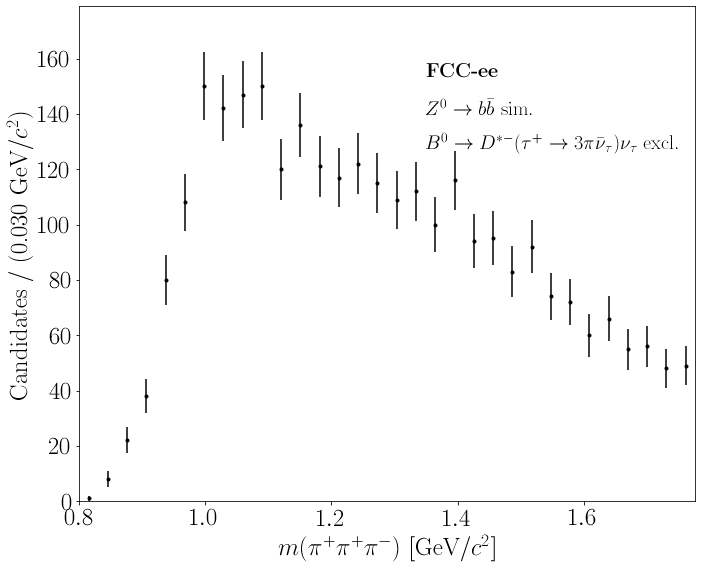

In [89]:
fig,ax = plt.subplots(figsize=(10,8))
low = 0.8
high = tau_m_high_cut_val
bin_width = 0.03
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(ak.flatten(B["tau","mass"]).tolist(), bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(\pi^+\pi^+\pi^-)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(1.35,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(1.35,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(1.35,0.74*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_Tau_M.pdf")

Fit the $\Delta M$ peak with zfit

In [95]:
low = Dst_Delta_M_low_cut_val
high = Dst_Delta_M_high_cut_val
obs = zfit.Space('mB', limits=(low, high))

#Signal PDF
rand = random.randint(0,9999)
mu = zfit.Parameter(f"mu_{rand}", 0.1455, low, high)
sigma = zfit.Parameter(f"sigma_{rand}", 0.004, 0.0001, 0.1)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.5, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 100., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.5, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.2, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaR, n=nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

In [91]:
data_np = ak.to_numpy(ak.flatten(B["Dst","Delta_M"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [96]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
#param_errors, _ = result.errors(method="minuit_minos")
param_errors = result.hesse()

print("m(D* - D0) fit function minimum:", result.fmin)
print("m(D* - D0) fit converged:", result.converged)
print("m(D* - D0) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.795e+04                 │       Ncalls = 610 (610 total)       │
│ EDM = 1.63e+03 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(D* - D0) fit function minimum: -17951.36207558812
m(D* - D0) fit converged: False
m(D* - D0) fit full minimizer information: {'n_eval': 610, 'n_iter': 610, 'original': FMin(fval=-17951.36207558812, edm=1627.938423823803, tolerance=1.0, nf

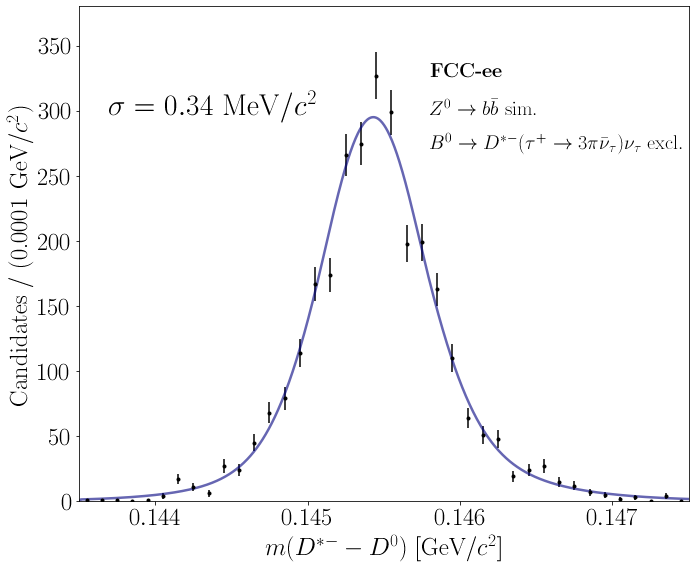

In [102]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.0001
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.4f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(D^{*-} - D^0)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(0.1458,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(0.1458,0.82*ymax,"$Z^0 \\to b \\bar{b}$ sim.",fontsize=20)
plt.text(0.1458,0.74*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
sigma_val = 1000.*params[sigma]['value']
plt.text(0.1437,0.82*ymax,"$\\sigma = %.2f$ MeV/$c^2$" % sigma_val,fontsize=30)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_Dst_Delta_M_fit.pdf")

In [94]:
#Number of Z's produced per year (4) per experiment (2)
N_Z = 3e12 * 0.25 * 0.5
#Number of b quarks produced
N_b = 2 * 0.1512 * N_Z
#Number of B0 -> D* tau nu produced, 
N_Bd2DstTauNu = N_b * 0.43 * 0.0157 * 0.677 * 0.0395 * 0.098

print("N expected per year per exp = %.3e" % N_Bd2DstTauNu)

N expected per year per exp = 2.006e+06
